In [8]:
from google.colab import drive # import drive from google colab

ROOT = "/content/drive"     # default location for the drive
print(ROOT)                 # print content of ROOT (Optional)

drive.mount(ROOT)
from os.path import join
MY_GOOGLE_DRIVE_PATH = 'My Drive/PortfolioProjects'
GIT_USERNAME = "shashanksharad"
GIT_TOKEN = "97c81b1457d0a8b5e3a8288a11206eb77457cc43"
GIT_REPOSITORY = "Multivariate-Time-Series-Forecasting"
PROJECT_PATH = join(ROOT, MY_GOOGLE_DRIVE_PATH)
GIT_PATH = "https://" + GIT_TOKEN + "@github.com/" + GIT_USERNAME + "/" + GIT_REPOSITORY + ".git" 
%cd "{PROJECT_PATH}"
%cd "{GIT_REPOSITORY}"
%cd 'src/'

/content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/PortfolioProjects
/content/drive/My Drive/PortfolioProjects/Multivariate-Time-Series-Forecasting
/content/drive/My Drive/PortfolioProjects/Multivariate-Time-Series-Forecasting/src


In [63]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestRegressor
plt.style.use('ggplot')

import seaborn as sns


Data Set Information:

The dataset contains 36733 instances of 11 sensor measures aggregated over one hour (by means of average or sum) from a gas turbine located in Turkey's north western region for the purpose of studying flue gas emissions, namely CO and NOx (NO + NO2). The data comes from the same power plant as the dataset ([Web Link]) used for predicting hourly net energy yield. By contrast, this data is collected in another data range (01.01.2011 - 31.12.2015), includes gas turbine parameters (such as Turbine Inlet Temperature and Compressor Discharge pressure) in addition to the ambient variables. Note that the dates are not given in the instances but the data are sorted in chronological order. See the attribute information and relevant paper for details. Kindly follow the protocol mentioned in the paper (using the first three years' data for training/ cross-validation and the last two for testing) for reproducibility and comparability of works. The dataset can be well used for predicting turbine energy yield (TEY) using ambient variables as features.


Attribute Information:

The explanations of sensor measurements and their brief statistics are given below.


Variable (Abbr.) Unit Min Max Mean

Ambient temperature (AT) C â€“6.23 37.10 17.71

Ambient pressure (AP) mbar 985.85 1036.56 1013.07

Ambient humidity (AH) (%) 24.08 100.20 77.87

Air filter difference pressure (AFDP) mbar 2.09 7.61 3.93

Gas turbine exhaust pressure (GTEP) mbar 17.70 40.72 25.56

Turbine inlet temperature (TIT) C 1000.85 1100.89 1081.43

Turbine after temperature (TAT) C 511.04 550.61 546.16

Compressor discharge pressure (CDP) mbar 9.85 15.16 12.06

Turbine energy yield (TEY) MWH 100.02 179.50 133.51

Carbon monoxide (CO) mg/m3 0.00 44.10 2.37

Nitrogen oxides (NOx) mg/m3 25.90 119.91 65.29

In [37]:
data_df = pd.DataFrame()
for year in [2011, 2012, 2013, 2014, 2015]:
  data_df = pd.concat([data_df, pd.read_csv('data/gt_{}.csv'.format(year))], ignore_index=True)
data_df['time'] = pd.date_range(start='1/1/2011', periods=len(data_df), freq='H')

data_df['Datetime'] = pd.to_datetime(data_df['time'])
data_df = data_df.set_index('Datetime')
print(data_df.head())
print(len(data_df))
print(data_df.columns)

                         AT      AP  ...     NOX                time
Datetime                             ...                            
2011-01-01 00:00:00  4.5878  1018.7  ...  81.952 2011-01-01 00:00:00
2011-01-01 01:00:00  4.2932  1018.3  ...  82.377 2011-01-01 01:00:00
2011-01-01 02:00:00  3.9045  1018.4  ...  83.776 2011-01-01 02:00:00
2011-01-01 03:00:00  3.7436  1018.3  ...  82.505 2011-01-01 03:00:00
2011-01-01 04:00:00  3.7516  1017.8  ...  82.028 2011-01-01 04:00:00

[5 rows x 12 columns]
36733
Index(['AT', 'AP', 'AH', 'AFDP', 'GTEP', 'TIT', 'TAT', 'TEY', 'CDP', 'CO',
       'NOX', 'time'],
      dtype='object')


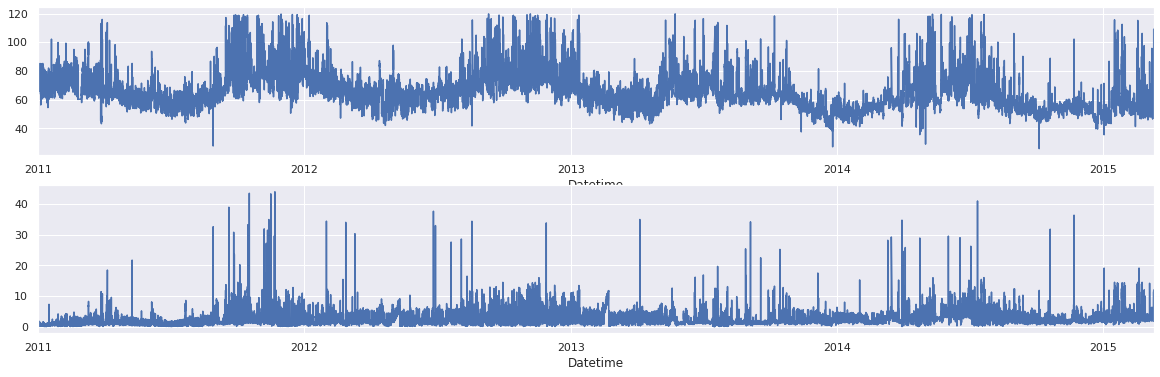

In [43]:
f,ax = plt.subplots(2, 1, figsize = (20, 6))
data_df["NOX"].plot(ax = ax[0])
data_df["CO"].plot(ax = ax[1])


In [45]:
data_df = data_df.resample('D').median()
data_df.head()

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
Datetime,,,,,,,,,,,
2011-01-01,5.42010,1017.45,84.5535,3.58260,23.9840,1086.15,549.815,134.675,11.8955,0.602055,82.0825
2011-01-02,11.73200,1011.75,81.8715,3.68890,24.2290,1085.85,549.840,133.670,11.8400,0.839660,77.1605
2011-01-03,8.37580,1009.05,95.6905,4.16210,28.1365,1092.80,540.380,147.150,12.8210,0.519285,71.6695
2011-01-04,7.31175,1020.25,87.2200,3.60465,23.6515,1085.40,549.795,134.465,11.9550,0.998430,82.3605
2011-01-05,7.26225,1021.95,81.7210,4.67285,32.4985,1099.60,528.550,161.400,14.0685,0.519390,68.5855


Index(['AT', 'AP', 'AH', 'AFDP', 'GTEP', 'TIT', 'TAT', 'TEY', 'CDP', 'CO',
       'NOX'],
      dtype='object')


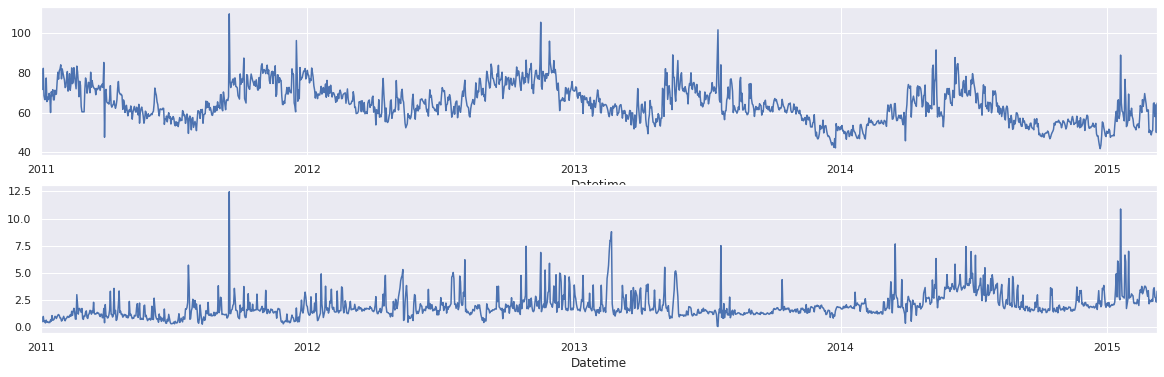

In [47]:
f,ax = plt.subplots(2, 1, figsize = (20, 6))
data_df["NOX"].plot(ax = ax[0])
data_df["CO"].plot(ax = ax[1])
print(data_df.columns)

In [54]:
# now define training dataset

def create_training_data(data_df):
  data_ml = data_df.copy()
  data_ml = data_ml.sort_index()
  features = ['AT', 'AP', 'AH', 'AFDP', 'GTEP', 'TIT', 'TAT', 'TEY', 'CDP']
  targets = ['CO','NOX']

  for col in features:
    data_ml[col+'_delta'] = data_ml[col]-data_ml[col].shift(1)
    data_ml[col+'_prev_1'] = data_ml[col].shift(1)
    data_ml[col+'_prev_2'] = data_ml[col].shift(2)
    data_ml[col+'_prev_3'] = data_ml[col].shift(3)
    data_ml[col+'_prev_4'] = data_ml[col].shift(4)
    data_ml[col+'_prev_5'] = data_ml[col].shift(5)

  for tar in targets:
    data_ml[tar+'_delta'] = data_ml[tar]- data_ml[tar].shift(1)
    data_ml[tar+'_prev_1'] = data_ml[tar].shift(1)
  return data_ml

In [55]:
df = create_training_data(data_df)
df.head()

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX,AT_delta,AT_prev_1,AT_prev_2,AT_prev_3,AT_prev_4,AT_prev_5,AP_delta,AP_prev_1,AP_prev_2,AP_prev_3,AP_prev_4,AP_prev_5,AH_delta,AH_prev_1,AH_prev_2,AH_prev_3,AH_prev_4,AH_prev_5,AFDP_delta,AFDP_prev_1,AFDP_prev_2,AFDP_prev_3,AFDP_prev_4,AFDP_prev_5,GTEP_delta,GTEP_prev_1,GTEP_prev_2,GTEP_prev_3,GTEP_prev_4,GTEP_prev_5,TIT_delta,TIT_prev_1,TIT_prev_2,TIT_prev_3,TIT_prev_4,TIT_prev_5,TAT_delta,TAT_prev_1,TAT_prev_2,TAT_prev_3,TAT_prev_4,TAT_prev_5,TEY_delta,TEY_prev_1,TEY_prev_2,TEY_prev_3,TEY_prev_4,TEY_prev_5,CDP_delta,CDP_prev_1,CDP_prev_2,CDP_prev_3,CDP_prev_4,CDP_prev_5,CO_delta,CO_prev_1,NOX_delta,NOX_prev_1
Datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-01-01,5.42010,1017.45,84.5535,3.58260,23.9840,1086.15,549.815,134.675,11.8955,0.602055,82.0825,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-02,11.73200,1011.75,81.8715,3.68890,24.2290,1085.85,549.840,133.670,11.8400,0.839660,77.1605,6.31190,5.42010,NaN,NaN,NaN,NaN,-5.7,1017.45,NaN,NaN,NaN,NaN,-2.6820,84.5535,NaN,NaN,NaN,NaN,0.10630,3.58260,NaN,NaN,NaN,NaN,0.2450,23.9840,NaN,NaN,NaN,NaN,-0.30,1086.15,NaN,NaN,NaN,NaN,0.025,549.815,NaN,NaN,NaN,NaN,-1.005,134.675,NaN,NaN,NaN,NaN,-0.0555,11.8955,NaN,NaN,NaN,NaN,0.237605,0.602055,-4.922,82.0825
2011-01-03,8.37580,1009.05,95.6905,4.16210,28.1365,1092.80,540.380,147.150,12.8210,0.519285,71.6695,-3.35620,11.73200,5.4201,NaN,NaN,NaN,-2.7,1011.75,1017.45,NaN,NaN,NaN,13.8190,81.8715,84.5535,NaN,NaN,NaN,0.47320,3.68890,3.5826,NaN,NaN,NaN,3.9075,24.2290,23.9840,NaN,NaN,NaN,6.95,1085.85,1086.15,NaN,NaN,NaN,-9.460,549.840,549.815,NaN,NaN,NaN,13.480,133.670,134.675,NaN,NaN,NaN,0.9810,11.8400,11.8955,NaN,NaN,NaN,-0.320375,0.839660,-5.491,77.1605
2011-01-04,7.31175,1020.25,87.2200,3.60465,23.6515,1085.40,549.795,134.465,11.9550,0.998430,82.3605,-1.06405,8.37580,11.7320,5.4201,NaN,NaN,11.2,1009.05,1011.75,1017.45,NaN,NaN,-8.4705,95.6905,81.8715,84.5535,NaN,NaN,-0.55745,4.16210,3.6889,3.5826,NaN,NaN,-4.4850,28.1365,24.2290,23.984,NaN,NaN,-7.40,1092.80,1085.85,1086.15,NaN,NaN,9.415,540.380,549.840,549.815,NaN,NaN,-12.685,147.150,133.670,134.675,NaN,NaN,-0.8660,12.8210,11.8400,11.8955,NaN,NaN,0.479145,0.519285,10.691,71.6695
2011-01-05,7.26225,1021.95,81.7210,4.67285,32.4985,1099.60,528.550,161.400,14.0685,0.519390,68.5855,-0.04950,7.31175,8.3758,11.7320,5.4201,NaN,1.7,1020.25,1009.05,1011.75,1017.45,NaN,-5.4990,87.2200,95.6905,81.8715,84.5535,NaN,1.06820,3.60465,4.1621,3.6889,3.5826,NaN,8.8470,23.6515,28.1365,24.229,23.984,NaN,14.20,1085.40,1092.80,1085.85,1086.15,NaN,-21.245,549.795,540.380,549.840,549.815,NaN,26.935,134.465,147.150,133.670,134.675,NaN,2.1135,11.9550,12.8210,11.8400,11.8955,NaN,-0.479040,0.998430,-13.775,82.3605


In [61]:
df.columns

Index(['AT', 'AP', 'AH', 'AFDP', 'GTEP', 'TIT', 'TAT', 'TEY', 'CDP', 'CO',
       'NOX', 'AT_delta', 'AT_prev_1', 'AT_prev_2', 'AT_prev_3', 'AT_prev_4',
       'AT_prev_5', 'AP_delta', 'AP_prev_1', 'AP_prev_2', 'AP_prev_3',
       'AP_prev_4', 'AP_prev_5', 'AH_delta', 'AH_prev_1', 'AH_prev_2',
       'AH_prev_3', 'AH_prev_4', 'AH_prev_5', 'AFDP_delta', 'AFDP_prev_1',
       'AFDP_prev_2', 'AFDP_prev_3', 'AFDP_prev_4', 'AFDP_prev_5',
       'GTEP_delta', 'GTEP_prev_1', 'GTEP_prev_2', 'GTEP_prev_3',
       'GTEP_prev_4', 'GTEP_prev_5', 'TIT_delta', 'TIT_prev_1', 'TIT_prev_2',
       'TIT_prev_3', 'TIT_prev_4', 'TIT_prev_5', 'TAT_delta', 'TAT_prev_1',
       'TAT_prev_2', 'TAT_prev_3', 'TAT_prev_4', 'TAT_prev_5', 'TEY_delta',
       'TEY_prev_1', 'TEY_prev_2', 'TEY_prev_3', 'TEY_prev_4', 'TEY_prev_5',
       'CDP_delta', 'CDP_prev_1', 'CDP_prev_2', 'CDP_prev_3', 'CDP_prev_4',
       'CDP_prev_5', 'CO_delta', 'CO_prev_1', 'NOX_delta', 'NOX_prev_1'],
      dtype='object')

In [59]:
list(df.iloc[-5:].index)

[Timestamp('2015-03-07 00:00:00', freq='D'),
 Timestamp('2015-03-08 00:00:00', freq='D'),
 Timestamp('2015-03-09 00:00:00', freq='D'),
 Timestamp('2015-03-10 00:00:00', freq='D'),
 Timestamp('2015-03-11 00:00:00', freq='D')]

In [83]:
def train_walk_forward_model(df, training_features, target_features, n_walks = 100, n_est = 100, mx_fts = None):
  data_df = df.dropna()
  for tar_cd, target_var in enumerate(target_features):
    data_X, data_y = data_df[training_features], data_df[[target_var]]
    test_pred_dGas = []

    for i in range(len(data_df)-n_walks, len(data_df)):
      X_train, X_test = data_X.iloc[:i], data_X.iloc[i:i+1]
      y_train_dGas, y_test_dGas = data_y.iloc[:i][target_var], data_y.iloc[i:i+1][target_var]

      model_dGas = RandomForestRegressor(n_estimators = n_est, min_samples_leaf = 11, random_state = 22, n_jobs = -1,
                                         bootstrap = True, max_features = mx_fts)
      model_dGas.fit(X_train, y_train_dGas)
      pred_train_dGas = model_dGas.predict(X_train)
      pred_test_dGas = model_dGas.predict(X_test)
      test_pred_dGas.append(pred_test_dGas)

    prev_gas_col_names = ['CO_prev_1', 'NOX_prev_1']
    prev_gas_col_name = prev_gas_col_names[tar_cd]

    pred_Gas = [list(data_df[prev_gas_col_name].iloc[-n_walks:])[t]+ test_pred_dGas[t] for t in range(len(test_pred_dGas))]
    plot_predictions(data_y.iloc[-n_walks:][target_var], test_pred_dGas, data_df[prev_gas_col_name[:-7]].iloc[-n_walks:], pred_Gas, list(data_df.iloc[-n_walks:].index), prev_gas_col_name[:-7])

def plot_predictions(actual_dGas, predicted_dGas, actual_gas, predicted_gas, dates, gas_type):
  f,ax = plt.subplots(2,1, figsize = (20, 6))
  ax[0].plot(dates, actual_dGas, label = 'Actual delta {} Emission'.format(gas_type))
  ax[0].plot(dates, predicted_dGas, label = 'Predicted delta {} Emission'.format(gas_type))
  ax[0].set_title('Test set for Delta {} Emission'.format(gas_type))
  ax[0].set_ylabel('Delta Emission {}'.format(gas_type))
  ax[0].legend()

  ax[1].plot(dates, actual_gas, label = 'Actual {} Emission'.format(gas_type))
  ax[1].plot(dates, predicted_gas, label = 'Predicted {} Emission'.format(gas_type))
  ax[1].set_title('Test set for {} Emission'.format(gas_type))
  ax[1].set_ylabel('Emission {}'.format(gas_type))
  ax[1].legend()

  f.tight_layout()
  

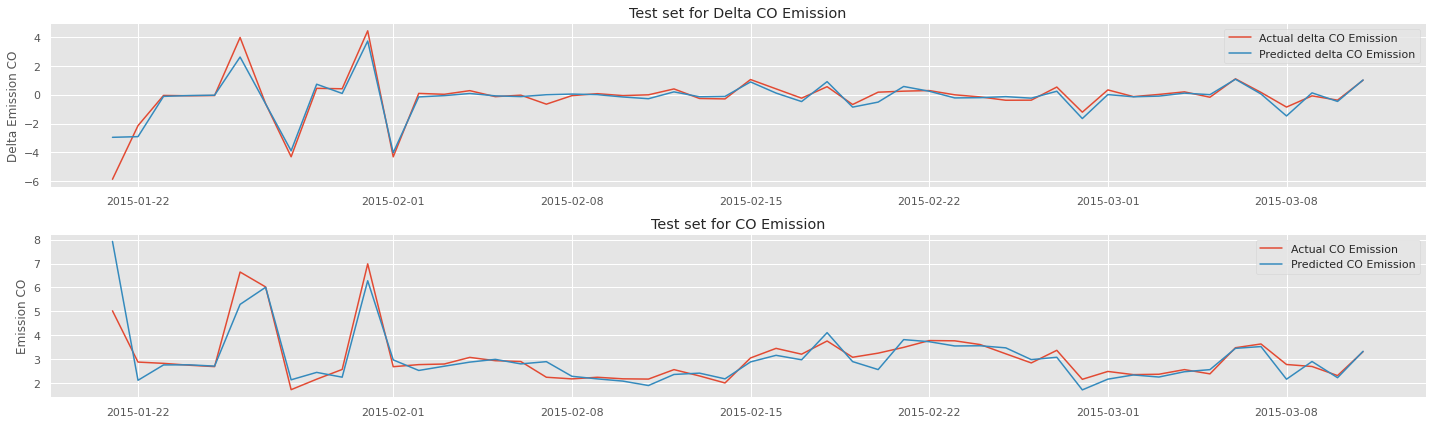

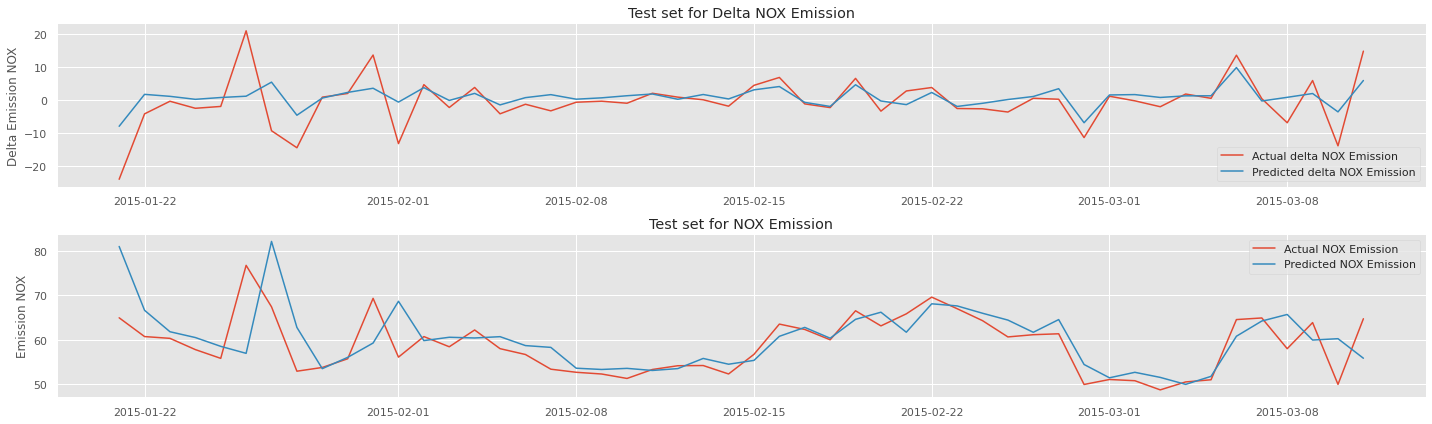

In [84]:
training_features = ['AT', 'AP', 'AH', 'AFDP', 'GTEP', 'TIT', 'TAT', 'TEY', 'CDP','AT_delta', 'AT_prev_1', 'AT_prev_2', 'AT_prev_3', 'AT_prev_4','AT_prev_5', 'AP_delta', 'AP_prev_1', 'AP_prev_2', 'AP_prev_3',
'AP_prev_4', 'AP_prev_5', 'AH_delta', 'AH_prev_1', 'AH_prev_2',
'AH_prev_3', 'AH_prev_4', 'AH_prev_5', 'AFDP_delta', 'AFDP_prev_1',
'AFDP_prev_2', 'AFDP_prev_3', 'AFDP_prev_4', 'AFDP_prev_5','GTEP_delta', 
'GTEP_prev_1', 'GTEP_prev_2', 'GTEP_prev_3',
'GTEP_prev_4', 'GTEP_prev_5', 'TIT_delta', 'TIT_prev_1', 'TIT_prev_2',
'TIT_prev_3', 'TIT_prev_4', 'TIT_prev_5', 'TAT_delta', 'TAT_prev_1',
'TAT_prev_2', 'TAT_prev_3', 'TAT_prev_4', 'TAT_prev_5', 'TEY_delta',
'TEY_prev_1', 'TEY_prev_2', 'TEY_prev_3', 'TEY_prev_4', 'TEY_prev_5',
'CDP_delta', 'CDP_prev_1', 'CDP_prev_2', 'CDP_prev_3', 'CDP_prev_4',
'CDP_prev_5', 'CO_prev_1', 'NOX_prev_1']

target_features = ['CO_delta', 'NOX_delta']

train_walk_forward_model(df, training_features, target_features, n_walks = 50, n_est = 100, mx_fts = None)

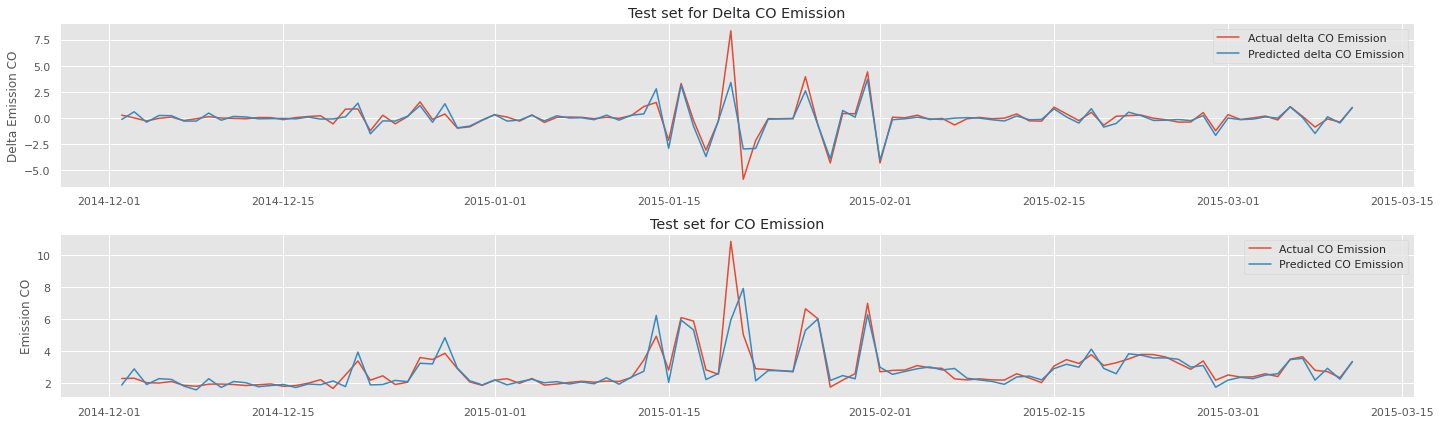

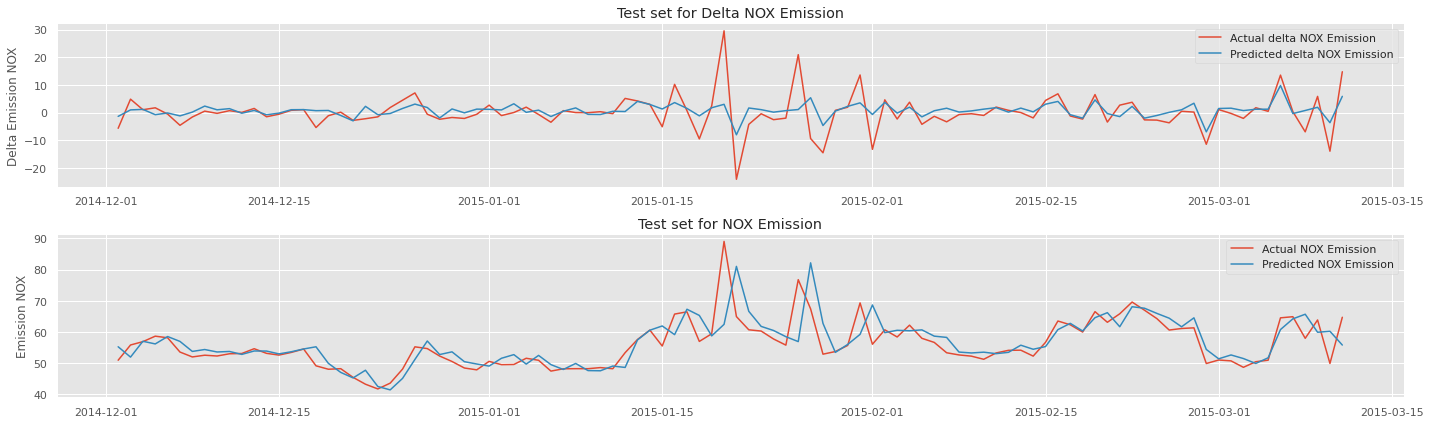

In [85]:
train_walk_forward_model(df, training_features, target_features, n_walks = 100, n_est = 100, mx_fts = None)